In [ ]:
#| default_exp clip_plot

In [ ]:
#| hide

%load_ext autoreload
%autoreload 2

# Imports and setup

### Unconditional imports

In [ ]:
#|export

from __future__ import division
import warnings

warnings.filterwarnings("ignore")

In [ ]:
#| export

# print separately that we're loading dependencies, as this can take a while
# and we want to give immediate feedback the program is starting
from clip_plot.utils import timestamp
print(timestamp(), "Beginning to load dependencies")


2023-06-23 17:20:02.486275: Beginning to load dependencies


In [ ]:
#|export

from fastcore.all import *
from tqdm.auto import tqdm

from clip_plot import utils
from clip_plot.utils import get_version, FILE_NAME
from clip_plot.embeddings import get_timm_embeds
from clip_plot.metadata import get_manifest, write_metadata
from clip_plot.images import write_images, create_atlas_files, ImageFactory

Setting ds_accelerator to cuda (auto detect)


2023-06-23 17:21:07.501057: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
#| export

from shutil import rmtree
from pathlib import Path
from typing import Optional, List, Union, Tuple
import uuid
import sys
import os

### Image processing imports

Note that I have removed the "copy-web-only" conditional import path for now

`nbdev` does not like cells to have cells to have code and imports in the same cell:

https://nbdev.fast.ai/getting_started.html#q-what-is-the-warning-found-a-cell-containing-mix-of-imports-and-computations.-please-use-separate-cells

I think this may mean we don't get to do conditional imports. If we find a code path that really should have conditional imports, we can see if there is a workaround. For now, I don't feel "copy web only" is a very important functionality to keep.

In [ ]:
#| export


import numpy as np
import random
import copy
import json

### Optional install imports

In [ ]:
#| export

DEFAULTS = {
    "images": None,
    "embeds": None,
    "meta_dir": None,
    "out_dir": "output",
    "max_images": None,
    "use_cache": True,
    "encoding": "utf8",
    "cluster_preproc_dims": -1,
    "min_cluster_size": 20,
    "max_clusters": 10,
    "atlas_size": 2048,
    "cell_size": 32,
    "lod_cell_height": 128, # Why is not in parser?
    "embed_model": "tf_inception_v3",
    "n_neighbors": [15],
    "min_dist": [0.01],
    "umap_on_full_dims": False,
    "n_components": 2,
    "metric": "correlation",
    "pointgrid_fill": 0.05,
    "gzip": False,
    "min_size": 100,
    "min_score": 0.3,
    "min_vertices": 18,
    "plot_id": str(uuid.uuid1()),
    "seed": 24,
    "n_clusters": 12,
    "geojson": None,
}

# handle truncated images in PIL (managed by Pillow)
PILLoadTruncated  = True

"""
NB: Keras Image class objects return image.size as w,h
    Numpy array representations of images return image.shape as h,w,c
"""

'\nNB: Keras Image class objects return image.size as w,h\n    Numpy array representations of images return image.shape as h,w,c\n'


## Entry

`process_images` will kick off all the main functions for the module

In [ ]:
#|export

def get_clip_plot_root() -> Path:
    # ipython doesn't have __file__ attribute
    if in_ipython():
        return Path(utils.__file__).parents[1]
    else:
        return Path(__file__).parents[1]

In [ ]:
#| export

def process_images(imageEngine, **kwargs):
    """
    Main method for processing user images and metadata
    It would be nice to list out the image processing steps before getting started
    """
    kwargs = preprocess_kwargs(**kwargs)
    print(timestamp(), "Starting image processing pipeline.")

    copy_web_assets(out_dir=kwargs['out_dir'])
    if kwargs["copy_web_only"]:
        print(timestamp(), "Done!")
        sys.exit()
    
    np.random.seed(kwargs["seed"])
    kwargs["out_dir"] = os.path.join(kwargs["out_dir"], "data")
    write_metadata(imageEngine, kwargs["gzip"], kwargs["encoding"])
    
    kwargs["atlas_dir"] = create_atlas_files(imageEngine, kwargs["plot_id"], kwargs["use_cache"])
    
    kwargs["vecs"] = get_timm_embeds(imageEngine, model_name=kwargs["embed_model"], **kwargs)
    get_manifest(imageEngine, **kwargs)
    write_images(imageEngine)
    print(timestamp(), "Done!")


def preprocess_kwargs(**kwargs):
    """Preprocess incoming key word arguments
    Converts n_neighbors and min_dist arguments into a list

    Args:
        n_neighbors (int, list[int], default = [15])
        min_dist (int, list[int], default = [0.01])

    Notes:
        Convenient hook for preprocessing arguments
    
    """
    for i in ["n_neighbors", "min_dist"]:
        if not isinstance(kwargs[i], list):
            kwargs[i] = [kwargs[i]]
    return kwargs

In [ ]:
#| export

def copy_web_assets(out_dir: str) -> None:
    """Copy the /web directory from the clipplot source to the users cwd.
    Copies version number into assets.
    
    Args: 
        out_dir (str): directory to copy web assets

    Returns:
        None
    """
    copy_root_dir = get_clip_plot_root()
    src = copy_root_dir / "clip_plot/web"

    # resolve will handle cases with ../ in the path
    dest = Path.cwd() / Path(out_dir).resolve()
    utils.copytree_agnostic(src.as_posix(), dest.as_posix())

    # write version numbers into output
    for i in ["index.html", os.path.join("assets", "js", "tsne.js")]:
        path = os.path.join(dest, i)
        with open(path, "r") as f:
            f = f.read().replace("VERSION_NUMBER", get_version())
            with open(path, "w") as out:
                out.write(f)


## Carlo's Test Functions
# Need to remove later

In [ ]:
#| export

copy_root_dir = get_clip_plot_root()

def test_iiif(config):
    test_images = copy_root_dir/"tests/IIIF_examples/iif_example.txt"
    test_out_dir = copy_root_dir/"tests/smithsonian_butterflies_10/output_test_temp"

    if Path(test_out_dir).exists():
        rmtree(test_out_dir)

    config["images"] = test_images.as_posix()
    config["out_dir"] = test_out_dir.as_posix()
    config["plot_id"] = "test_diff"

    return config


def test_butterfly_duplicate(config):
    test_images = copy_root_dir/"tests/smithsonian_butterflies_10/jpgs_duplicates/**/*.jpg"
    test_out_dir = copy_root_dir/"tests/smithsonian_butterflies_10/output_test_temp"
    meta_dir = copy_root_dir/"tests/smithsonian_butterflies_10/meta_data/good_meta.csv"
    if Path(test_out_dir).exists():
        rmtree(test_out_dir)

    config["images"] = test_images.as_posix()
    config["out_dir"] = test_out_dir.as_posix()
    config["meta_dir"] = meta_dir.as_posix()
    config["plot_id"] = "test_diff"

    return config


def test_butterfly(config):
    test_images = copy_root_dir/"tests/smithsonian_butterflies_10/jpgs/*.jpg"
    test_out_dir = copy_root_dir/"tests/smithsonian_butterflies_10/output_test_temp"
    meta_dir = copy_root_dir/"tests/smithsonian_butterflies_10/meta_data/good_meta.csv"
    if Path(test_out_dir).exists():
        rmtree(test_out_dir)

    config["images"] = test_images.as_posix()
    config["out_dir"] = test_out_dir.as_posix()
    config["meta_dir"] = meta_dir.as_posix()
    config["plot_id"] = "test_diff"
    
    config["test_mode"] = True

    return config


def test_butterfly_missing_meta(config):
    test_images = copy_root_dir/"tests/smithsonian_butterflies_10/jpgs/*.jpg"
    test_out_dir = copy_root_dir/"tests/smithsonian_butterflies_10/output_test_temp"
    meta_dir = copy_root_dir/"tests/smithsonian_butterflies_10/meta_data/meta_missing_entry.csv"
    if Path(test_out_dir).exists():
        rmtree(test_out_dir)

    config["images"] = test_images.as_posix()
    config["out_dir"] = test_out_dir.as_posix()
    config["meta_dir"] = meta_dir.as_posix()
    config["plot_id"] = "test_diff"

    return config


def test_no_meta_dir(config):
    test_images = copy_root_dir/"tests/smithsonian_butterflies_10/jpgs/*.jpg"
    test_out_dir = copy_root_dir/"tests/smithsonian_butterflies_10/output_test_temp"
    if Path(test_out_dir).exists():
        rmtree(test_out_dir)

    config["images"] = test_images.as_posix()
    config["out_dir"] = test_out_dir.as_posix()
    config["plot_id"] = "test_diff"

    return config


# Parse the command-line arguments

In [ ]:
#| export

@call_parse
def project_imgs(images:Param(type=str,
                        help="path or glob of images to process"
                        )=DEFAULTS["images"],
                embeds:Param(type=str,
                        help="path or glob of embeddings to process (must match images folder/file structure)"
                        )=DEFAULTS["embeds"],
                metadata:Param(type=str,
                        help="path to a csv or glob of JSON files with image metadata (see readme for format)"
                        )=DEFAULTS["meta_dir"],
                max_images:Param(type=int,
                        help="maximum number of images to process"
                        )=DEFAULTS["max_images"],
                use_cache:Param(type=store_true,
                        help="given inputs identical to prior inputs, load outputs from cache"
                        )=DEFAULTS["use_cache"],
                encoding:Param(type=str,
                        help="the encoding of input metadata"
                        )=DEFAULTS["encoding"],
                cluster_preproc_dims:Param(type=int,
                        help="number of dims to reduce to prior to clustering. -1 means don't reduce",
                        required=False
                        )=DEFAULTS["cluster_preproc_dims"],
                min_cluster_size:Param(type=int,
                        help="the minimum number of images in a cluster",
                        required=False
                        )=DEFAULTS["min_cluster_size"],
                max_clusters:Param(type=int,
                        help="the maximum number of clusters to return",
                        required=False
                        )=DEFAULTS["max_clusters"],
                out_dir:Param(type=str,
                        help="the directory to which outputs will be saved",
                        required=False
                        )=DEFAULTS["out_dir"],
                cell_size:Param(type=int,
                        help="the size of atlas cells in px",
                        required=False
                        )=DEFAULTS["cell_size"],
                embed_model:Param(type=str,
                        help="pre-trained model from timm library to use to create embedding",
                        required=False
                        )=DEFAULTS["embed_model"],
                n_neighbors:Param(type=int,
                        nargs="+",
                        help="the n_neighbors arguments for UMAP"
                        )=DEFAULTS["n_neighbors"],
                min_dist:Param(type=float,
                        nargs="+",
                        help="the min_dist arguments for UMAP"
                        )=DEFAULTS["min_dist"],
                umap_on_full_dims:Param(type=store_true,
                        help="perform PCA prior to main dimensionality reduction"
                        )=DEFAULTS["umap_on_full_dims"],
                n_components:Param(type=int,
                        help="the n_components argument for UMAP"
                        )=DEFAULTS["n_components"],
                metric:Param(type=str,
                        help="the metric argument for umap"
                        )=DEFAULTS["metric"],
                pointgrid_fill:Param(type=float,
                        help="float 0:1 that determines sparsity of jittered distributions (lower means more sparse)"
                        )=DEFAULTS["pointgrid_fill"],
                copy_web_only:Param(type=store_true,
                        help="update ./output/assets without reprocessing data"
                        )=False,
                min_size:Param(type=float,
                        help="min size of cropped images"
                        )=DEFAULTS["min_size"],
                gzip:Param(type=store_true,
                        help="save outputs with gzip compression"
                        )=False,
                shuffle:Param(type=store_true,
                        help="shuffle the input images before data processing begins"
                        )=False,
                plot_id:Param(type=str,
                        help="unique id for a plot; useful for resuming processing on a started plot"
                        )=DEFAULTS["plot_id"],
                seed:Param(type=int, help="seed for random processes"
                           )=DEFAULTS["seed"],
                n_clusters:Param(type=int,
                        help="number of clusters if using kmeans"
                        )=DEFAULTS["n_clusters"],
                geojson:Param(type=str,
                        help="path to a GeoJSON file with shapes to be rendered on a map"
                        )=DEFAULTS["geojson"]
                ):
                "Convert a folder of images into a clip-plot visualization"

                # grab local variables as configuration dict
                config = dict(locals())

                # some parameters exist in DEFAULTS but not in the function signature
                default_only_keys = set(set(DEFAULTS.keys() - config.keys()))
                default_only = {k:DEFAULTS[k] for k in default_only_keys}
                config.update(default_only)


                if in_ipython() and config["images"] == None:
                        print("Clip-plot is being run from ipython")
                        # at least for now, this means we're in testing mode.
                        # TODO: pass explicit "test_mode" flag
                        config = test_butterfly(config)

                options = {
                        'shuffle': config['shuffle'], 
                        'seed': config['seed'], 
                        'max_images': config['max_images'], 
                        'atlas_size': config['atlas_size'], 
                        'cell_size': config['cell_size'], 
                        'lod_cell_height': config['lod_cell_height'], 
                        'validate': True, 
                }

                out_dir = os.path.join(config["out_dir"], "data")
                imageEngine = ImageFactory(config['images'], out_dir, config['meta_dir'], options)
                
                process_images(imageEngine, **config)

Clip-plot is being run from ipython
2023-06-23 17:10:44.897662: Validating input images


  0%|          | 0/12 [00:00<?, ?it/s]

2023-06-23 17:10:45.352732: Starting image processing pipeline.
2023-06-23 17:10:45.364383: Creating atlas files


  0%|          | 0/12 [00:00<?, ?it/s]

2023-06-23 17:10:46.109949: Creating embeddings using tf_inception_v3
CUDA is available? True


  0%|          | 0/12 [00:00<?, ?it/s]

2023-06-23 17:10:51.459387: Creating single umap layout
2023-06-23 17:10:56.203094: Creating umap pointgrid
2023-06-23 17:10:56.220215: Creating grid layout
2023-06-23 17:10:56.220795: Creating rasterfairy layout
2023-06-23 17:10:56.723588: Coonswarp rectification could not be performed list index out of range
2023-06-23 17:10:56.724943: Creating categorical layout
2023-06-23 17:10:56.725395: Creating date layout
2023-06-23 17:10:56.725432: Creating date layout with 3 columns
2023-06-23 17:10:56.726273: Attempt to create geographic layout
2023-06-23 17:10:56.726326: Creating geographic layout
2023-06-23 17:10:56.726476: Creating custom layout based on xy coordinates in metadata
2023-06-23 17:10:56.726876: Creating custom layout
2023-06-23 17:10:57.110384: Clustering data with hdbscan
2023-06-23 17:10:57.114088: Found 0 hotspots
2023-06-23 17:10:57.115097: Copying images to output directory


  0%|          | 0/12 [00:00<?, ?it/s]

2023-06-23 17:10:58.121863: Done!


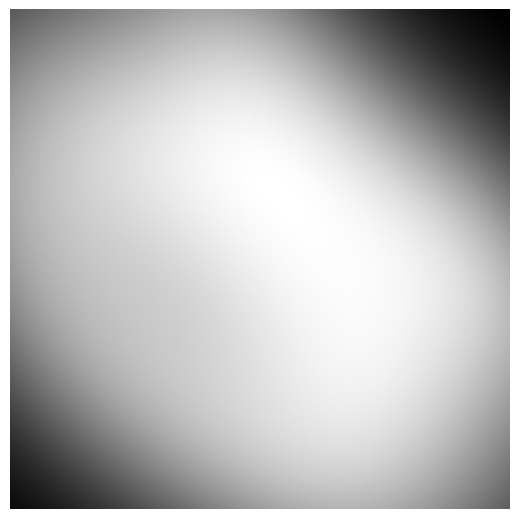

In [ ]:
#| export

if __name__ == "__main__":
    project_imgs()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()